# Table of Contents

- [0. Part 0 - Beginning](#0-part-0---beginning-of-the-file)
  - [0.1 Overview](#01-overview)
  - [0.2 Libraries](#02-libraries)
  - [0.3 Work To Do](#03-work-to-do)


- [I. Part A - Marcand : One Configuration](#i-part-a---one-configuration)
  - [I.1 File Reading](#i1-file-reading)
  - [I.2 Extracting All Values](#i2-extracting-all-values)
  - [I.3 Illustrating](#i3-illustrating)

- [II. Part B - Marcand : Comparison of Configurations](#ii-part-b---comparison-of-configurations)
  - [II.1 Parquet Fusion](#ii1-parquet-fusion)
  - [II.2 Verifying Datas](#ii2-verifying-datas)
  - [II.3 Computing Heatmaps](#ii3-computing-heatmaps)
  - [II.4 Plotting Heatmaps](#ii4-plotting-heatmaps)

- [III. Part C - Marcand : Graphical Representations (3D)](#iii-part-c---graphical-representations-3d)
  - [III.1 Dynamic Representation in 3D](#iii1-dynamic-representation-in-3d)


# 0. Part 0 - Beginning

## 0.1 Overview

This notebook is structured to analyze and visualize simulation results for nucleosome-related configurations. It is divided into several clearly defined parts:

- **Part 0** initializes the environment and loads the necessary libraries.
- **Part A** focuses on a **single configuration**, where relevant data is read, plotted, and analyzed in detail.
- **Part B** compares **multiple configurations** by merging and filtering data from Parquet files, computing key metrics, and generating heatmaps.
- **Part C** provides **graphical representations**, including:
  - A dynamic 3D visualization to capture spatiotemporal behaviors,
  - 1D visual summaries using both single and multiple plots.

Each part is modular and can be almost run independently for clarity and reproducibility. The goal is to facilitate both **exploratory analysis** and **publication-quality figures**.

## 0.2 Libraries

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# System and files
import os
import time
import pickle
import logging
from tqdm import tqdm
from datetime import datetime
from pathlib import Path
from collections import defaultdict
from dataclasses import dataclass

# Files and data
import itertools
import numpy as np
import polars as pl
import fastparquet as fp
import pyarrow.parquet as pq

# Vizualization
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from tqdm import tqdm

# Maths
from scipy.optimize import curve_fit
from random import *
import math

# Personal
import sys
library_path = Path.home() / "Documents" / "PhD" / "Workspace" / "outline" / "src"
sys.path.append(str(library_path))
import plot_tools as plts

# I. Part A - Marcand : One configuration

## I.1 File Reading

In [25]:
def mrc_find_parquet_and_load(
    base_folder: Path = Path.home() / "Documents" / "PhD" / "Workspace" / "marcand" / "outputs",
    **params
) -> pl.DataFrame:
    """
    Finds the corresponding data file 
    """
    try:
        alpha_choice = params["alpha_choice"]
        gap = params["gap"]
        mu = params["mu"]
        theta = params["theta"]
        nt = params["nt"]
    except KeyError as e:
        raise ValueError(f"Paramètre manquant : {e}")

    folder_target = f"alphachoice={alpha_choice}={gap}_mu={mu}_theta={theta}_nt={nt}"
    found = False
    full_path = None

    for root, dirs, _ in os.walk(base_folder):
        for subfolder in dirs:
            if subfolder == folder_target:
                full_path = os.path.join(root, subfolder)
                if os.path.isdir(full_path):
                    found = True
                    print(f"Dossier trouvé : {full_path}")
                    break
        if found:
            break

    if not found or full_path is None:
        raise FileNotFoundError(
            f"Aucun dossier nommé '{folder_target}' trouvé dans les sous-dossiers de '{base_folder}'."
        )

    # Cherche le fichier .parquet dans le dossier trouvé
    parquet_files = [f for f in os.listdir(full_path) if f.endswith(".parquet")]
    if not parquet_files:
        raise FileNotFoundError(f"Aucun fichier .parquet trouvé dans le dossier '{full_path}'.")

    parquet_path = os.path.join(full_path, parquet_files[0])
    data = pq.read_table(parquet_path)
    df_polars = pl.DataFrame(data)

    if df_polars.is_empty():
        raise ValueError("Le DataFrame Polars est vide — aucun résultat à traiter.")

    return df_polars


# Parameters
params = {
    "alpha_choice": "array_gap",
    "gap": 25,
    "bpmin": 0,
    "mu": 200,
    "theta": 30,
    "nt": 10_000,
    "dt": 1,
    "alphao": 0,
    "alphaf": 1,
    "beta": 0
}

# Call
df_polars = mrc_find_parquet_and_load(**params)

FileNotFoundError: Aucun dossier nommé 'alphachoice=array_gap=25_mu=200_theta=30_nt=10000' trouvé dans les sous-dossiers de 'C:\Users\nicol\Documents\PhD\Workspace\marcand\outputs'.

# I.2 Extracting All Values

In [ ]:
@dataclass
class SimulationData:
    # Inputs
    alpha_choice: str
    gap: int
    bpmin: int
    mu: float
    theta: float
    nt: int
    dt: float
    N: int
    alphao: float
    alphaf: float
    beta: float
    total_lenght: int
    bps: int
    xo: int

    # Obstacle
    alpha_mean: np.ndarray
    obs_points: np.ndarray
    obs_distrib: np.ndarray
    link_points: np.ndarray
    link_distrib: np.ndarray

    # Probabilities
    p: np.ndarray

    # Results
    results: np.ndarray
    fpt_mean: np.ndarray
    fpt_2D: np.ndarray
    fpt_xmax_1D: np.ndarray
    p_tau: np.ndarray
    v_marcand: float
    delay: np.ndarray

    # First Passage Times
    bin_fpt: int
    fpt_distrib_2D: np.ndarray
    fpt_number: np.ndarray

    # Times Between Jumps
    tbj_points: np.ndarray
    tbj_distrib: np.ndarray

    # Instantaneous Statistics
    dx_points: np.ndarray
    dx_distrib: np.ndarray
    dx_mean: float
    dx_med: float
    dx_mp: float

    dt_points: np.ndarray
    dt_distrib: np.ndarray
    dt_mean: float
    dt_med: float
    dt_mp: float

    vi_points: np.ndarray
    vi_distrib: np.ndarray
    vi_mean: float
    vi_med: float
    vi_mp: float

    # Last parameters
    alpha_0: float


def mrc_extract_simulation_data(df_polars: pl.DataFrame) -> SimulationData:
    return SimulationData(
        # Inputs
        alpha_choice=df_polars['alpha_choice'][0],
        gap=df_polars['gap'][0],
        bpmin=df_polars['bpmin'][0],
        mu=df_polars['mu'][0],
        theta=df_polars['theta'][0],
        nt=df_polars['nt'][0],
        dt=df_polars['dt'][0],
        N=df_polars['N'][0],
        alphao=df_polars['alphao'][0],
        alphaf=df_polars['alphaf'][0],
        beta=df_polars['beta'][0],
        total_lenght=df_polars['total_lenght'][0],
        bps=df_polars['bps'][0],
        xo=df_polars['xo'][0],

        # Obstacle
        alpha_mean=df_polars['alpha_mean'][0].to_numpy(),
        obs_points=df_polars['obs_points'][0].to_numpy(),
        obs_distrib=df_polars['obs_distrib'][0].to_numpy(),
        link_points=df_polars['link_points'][0].to_numpy(),
        link_distrib=df_polars['link_distrib'][0].to_numpy(),

        # Probabilities
        p=df_polars['p'][0].to_numpy(),

        # Results
        results=np.array(df_polars["results"].to_list())[0],
        fpt_mean=df_polars['fpt_mean'][0].to_numpy(),
        fpt_2D=np.array(df_polars["fpt_2D"].to_list())[0],
        fpt_xmax_1D=df_polars['fpt_xmax_1D'][0].to_numpy(),
        p_tau=df_polars['p_tau'][0].to_numpy(),
        v_marcand=df_polars['v_marcand'][0],
        delay=df_polars['delay'][0].to_numpy(),

        # First Passage Times
        bin_fpt=df_polars['bin_fpt'][0],
        fpt_distrib_2D=np.array(df_polars["fpt_distrib_2D"].to_list())[0],
        fpt_number=df_polars['fpt_number'][0].to_numpy(),

        # Times Between Jumps
        tbj_points=df_polars['tbj_points'][0].to_numpy(),
        tbj_distrib=df_polars['tbj_distrib'][0].to_numpy(),

        # Instantaneous Statistics
        dx_points=df_polars['dx_points'][0].to_numpy(),
        dx_distrib=df_polars['dx_distrib'][0].to_numpy(),
        dx_mean=df_polars['dx_mean'][0],
        dx_med=df_polars['dx_med'][0],
        dx_mp=df_polars['dx_mp'][0],

        dt_points=df_polars['dt_points'][0].to_numpy(),
        dt_distrib=df_polars['dt_distrib'][0].to_numpy(),
        dt_mean=df_polars['dt_mean'][0],
        dt_med=df_polars['dt_med'][0],
        dt_mp=df_polars['dt_mp'][0],

        vi_points=df_polars['vi_points'][0].to_numpy(),
        vi_distrib=df_polars['vi_distrib'][0].to_numpy(),
        vi_mean=df_polars['vi_mean'][0],
        vi_med=df_polars['vi_med'][0],
        vi_mp=df_polars['vi_mp'][0],

        # Last parameters
        alpha_0=df_polars['alpha_0'][0],
    )


# Extracting
sim_data = mrc_extract_simulation_data(df_polars)
print(sim_data.fpt_mean)
print("Values loaded")

## I.3 Illustrating

In [ ]:
# Plot
plts.mrc_plot_summary(
    sim_data.gap, sim_data.mu, sim_data.theta,
    sim_data.alpha_mean, sim_data.p, 
    sim_data.fpt_mean, sim_data.fpt_2D, sim_data.fpt_xmax_1D, 
    sim_data.p_tau, sim_data.v_marcand
)

# Pe etre fpt_2D_clean à mettre

NameError: name 'sim_data' is not defined

# II. Part B - Comparison of Configurations

## II.1 Parquet Fusion

In [ ]:
# --- Dialog box to merge all the parquet files together --- #

def ask_confirmation_input():
    response = input("Are you sure you want to merge all the parquet files? (Yes/No): ")
    if response != "Yes":
        raise RuntimeError("Stopped by the user.")

ask_confirmation_input()
print("Ready.")

In [ ]:
# --- Big fusion --- #

def mrc_merging_parquet_files(root_directory, nt):
    """
    Merges all the .parquet files from our simulations while filtering only columns of types str, i64, and f64.

    Args:
        root_directory (str): Root directory containing subfolders.
        L_max (int): Filter parameter for subfolders.
        n_t (int): Filter parameter for subfolders.

    Returns:
        None
    """

    os.chdir(root_directory)  # Navigate to root directory to avoid unwanted paths
    print("Launched at:", os.getcwd())

    # Main result storage
    dataframes = []

    # List of subfolders to check in the root folder
    subdirs = [os.path.join(root_directory, d) for d in os.listdir(root_directory) if os.path.isdir(os.path.join(root_directory, d))]

    # Main loop
    for subdir in tqdm(subdirs, desc="Loading subfiles", unit=" subfiles"):
        for dirpath, dirnames, filenames in os.walk(subdir):
            for dirname in dirnames:
                folder_name = dirname
                # Verification
                if (f"nt={nt}" in folder_name):
                    # Path of the corresponding subfolder
                    subdir_path = os.path.join(dirpath, folder_name)

                    for filename in os.listdir(subdir_path):
                        if filename.endswith('.parquet') and 'data' in filename:
                            pq_path = os.path.join(subdir_path, filename)

                            try:
                                # Read the parquet file
                                df_parquet = pl.read_parquet(pq_path)

                                # Filter only columns of type str, i64, or f64
                                filtered_df = df_parquet.select([
                                    col for col, dtype in zip(df_parquet.columns, df_parquet.dtypes)
                                    if dtype in [pl.Utf8, pl.Int64, pl.Float64]
                                ])
                                
                                dataframes.append(filtered_df)

                            except Exception as e:
                                print(f"Error loading Parquet file: {e}")
    
    # Concatenate and write the final result
    if dataframes:
        merged_df = pl.concat(dataframes)
        last_address = f'{root_directory}/mrc_output.parquet'
        merged_df.write_parquet(last_address)
        print(f"All files merged and saved to {last_address}.")
    else:
        print("No Parquet files found that match the criteria.")

    return None


# --- Launching --- #
root = "/home/nicolas/Documents/PhD/Workspace/marcand/outputs"
mrc_merging_parquet_files(root_directory=root, nt=10_000)

## II.2 Verifying Datas

In [ ]:
# Getting the file with Polars and performing verifications
def mrc_getting_main_file_and_verification(
    df: pl.DataFrame,
    nt: int = 10_000
) -> pl.DataFrame:
    """
    Filters a Polars DataFrame based on specific criteria.

    Args:
        df (pl.DataFrame): The input DataFrame containing the dataset.
        nt (int, default=1000): Number of time steps in the simulation.
        tmax (int, default=100000): Maximum simulation time.
        dt (int): Time step interval.
        alphao (float, default=0.5): Initial alpha value.
        alphaf (float, default=0.5): Final alpha value.
        beta (float, default=1.0): Beta value used in the simulation.
        Lmin (int, default=0): Minimum linker length.
        Lmax (int, default=500): Maximum linker length.
        origin (int, default=0): Origin value used in the setup.
        bps (int, default=10): Base pairs per step.

    Returns:
        pl.DataFrame: The filtered DataFrame based on the given parameters.
    """

    selected_columns = {
        'alpha_choice', 'gap', 'bpmin', 'mu', 'theta', 
        'nt', 'dt', 'N', 
        'alphao', 'alphaf', 'beta', 
        'total_lenght', 'origin', 'bps',

        'v_marcand', 'delay',
    }

    # Select only the required columns
    filtered_columns = [col for col in df.columns if col in selected_columns]
    filtered_df = df.select(filtered_columns)

    # Apply filtering based on predefined conditions
    filtered_df = (
        filtered_df
        .filter(pl.col("nt") == nt)
    )

    return filtered_df


# Reading it for further manipulations
main_folder_path = Path.home() / "Documents" / "PhD" / "Workspace" / "marcand" / "outputs"
print("Available outputs :", os.listdir(main_folder_path))
main_file_path = main_folder_path / "mrc_output.parquet"
data = pq.read_table(main_file_path)
df_polars = pl.DataFrame(data)

# Loading file + Filtering
df_pl_main = mrc_getting_main_file_and_verification(df_polars)
print('The df_polars containing the int and floats for all our simulations :\nTotal shape :',df_pl_main.shape, '\nQuick print and shape :', df_pl_main.head(5))

## II.3 Computing Heatmaps

In [ ]:
# Availabilities of datas

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    df_pl_main["mu"],
    df_pl_main["theta"],
    c=df_pl_main["gap"],
    cmap="plasma",
    marker="+"
)
plt.colorbar(sc, label="lmbda")
plt.title("Scatter plot")
plt.show()


filtered = df_pl_main.filter(
    (df_pl_main["bpmin"] == 0) &
    (df_pl_main["gap"] == 15) &
    (df_pl_main["mu"] == 77) &
    (df_pl_main["theta"] == 35)
)
print(filtered)

## II.4 Plotting Heatmaps

In [4]:
import os
import polars as pl
from dataclasses import dataclass
from typing import List

@dataclass
class SimulationParams:
    """Container for physical simulation parameters."""
    gap: int
    k: int
    theta: float

# Chemin de base
base_path = "C:\Documents\PhD\Work\PhD\marcand\outputs"

# Initialisation du DataFrame final
df_pl_mrc = pl.DataFrame()

# Exploration récursive
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith(".parquet"):
            full_path = os.path.join(root, file)
            try:
                df = pl.read_parquet(full_path)
                print(df)
                # Vérifie que les colonnes nécessaires existent
                if all(col in df.columns for col in ["gap", "mu", "theta", "v_marcand"]):
                    df_selected = df.select(["gap", "k", "theta", "v_marcand"])
                    df_pl_mrc = pl.concat([df_pl_mrc, df_selected])
            except Exception as e:
                print(f"Erreur avec {full_path} : {e}")

print(df_pl_mrc)


shape: (70_000, 25)
┌──────────────┬─────┬───────┬─────┬───┬───────┬─────────────┬────────────┬───────┐
│ alpha_choice ┆ gap ┆ bpmin ┆ mu  ┆ … ┆ dt_mp ┆ vi_mean     ┆ vi_med     ┆ vi_mp │
│ ---          ┆ --- ┆ ---   ┆ --- ┆   ┆ ---   ┆ ---         ┆ ---        ┆ ---   │
│ str          ┆ i64 ┆ i64   ┆ i64 ┆   ┆ f64   ┆ f64         ┆ f64        ┆ f64   │
╞══════════════╪═════╪═══════╪═════╪═══╪═══════╪═════════════╪════════════╪═══════╡
│ array        ┆ 35  ┆ 2     ┆ 81  ┆ … ┆ 0.5   ┆ 1082.682519 ┆ 73.991894  ┆ 2.5   │
│ array        ┆ 35  ┆ 2     ┆ 69  ┆ … ┆ 0.5   ┆ 807.599065  ┆ 78.237298  ┆ 17.5  │
│ array        ┆ 35  ┆ 2     ┆ 21  ┆ … ┆ 0.5   ┆ inf         ┆ inf        ┆ 0.5   │
│ array        ┆ 35  ┆ 2     ┆ 81  ┆ … ┆ 0.5   ┆ inf         ┆ inf        ┆ 0.5   │
│ array        ┆ 35  ┆ 2     ┆ 39  ┆ … ┆ 0.5   ┆ inf         ┆ inf        ┆ 0.5   │
│ …            ┆ …   ┆ …     ┆ …   ┆ … ┆ …     ┆ …           ┆ …          ┆ …     │
│ array        ┆ 20  ┆ 0     ┆ 121 ┆ … ┆ 0.5   ┆ 2178.48

<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nicol\AppData\Local\Temp\ipykernel_21548\4141258625.py:14: SyntaxWarning: invalid escape sequence '\D'
  base_path = "C:\Documents\PhD\Work\PhD\marcand\outputs"


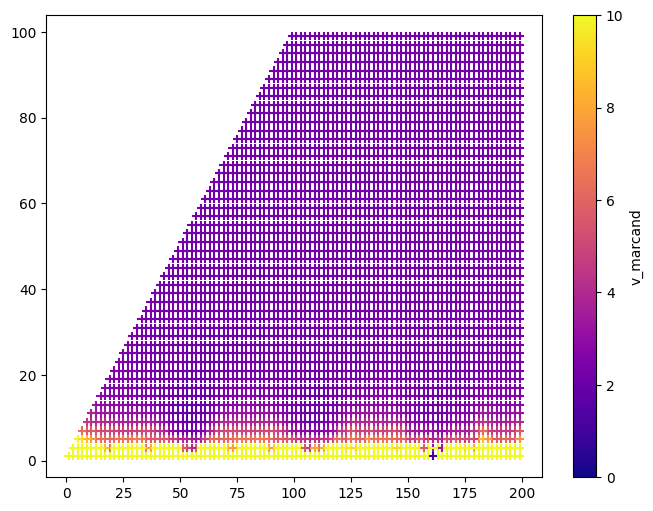

In [35]:
df_gap5 = df.filter((df["bpmin"] != 2) & (df["gap"] == 25))

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

norm = mcolors.Normalize(vmin=0, vmax=10)

plt.figure(figsize=(8, 6))
sc = plt.scatter(
    df_gap5["mu"], df_gap5["theta"],
    c=df_gap5["v_marcand"],
    cmap="plasma",
    norm=norm,
    marker="+"
)
plt.colorbar(sc, label="v_marcand")
plt.show()

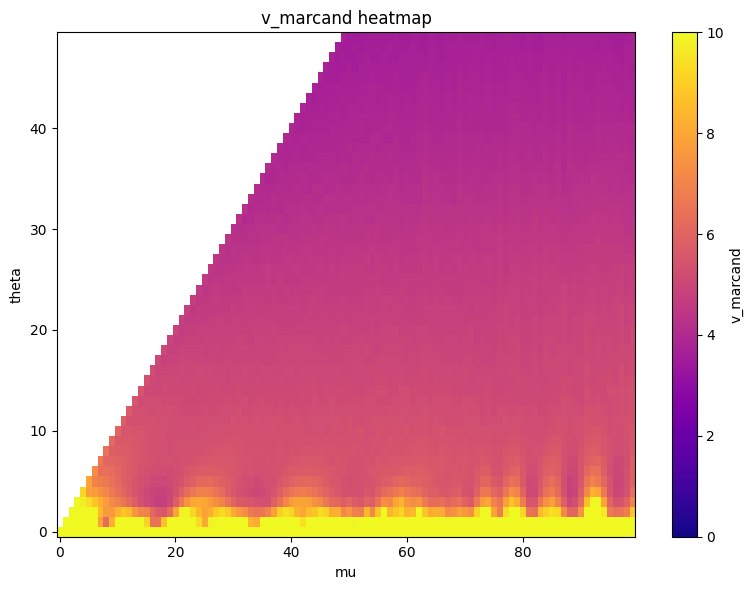

In [34]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Convertir Polars → Pandas temporairement pour pivot
df_pandas = df_gap5.to_pandas()

# Pivot table : lignes = theta, colonnes = mu
pivot = df_pandas.pivot(index="theta", columns="mu", values="v_marcand")

# Tri des axes (optionnel, si nécessaire)
pivot = pivot.sort_index(axis=0).sort_index(axis=1)

# Créer la figure avec imshow
plt.figure(figsize=(8, 6))
norm = mcolors.Normalize(vmin=0, vmax=10)

im = plt.imshow(pivot, aspect="auto", origin="lower", cmap="plasma", norm=norm)
# im = plt.imshow(pivot, aspect="auto", origin="lower", cmap="plasma", norm=norm, interpolation="nearest")

# # Axes ticks
# plt.xticks(ticks=np.arange(len(pivot.columns)), labels=pivot.columns)
# plt.yticks(ticks=np.arange(len(pivot.index)), labels=pivot.index)

plt.xlabel("mu")
plt.ylabel("theta")
plt.title("v_marcand heatmap")

plt.colorbar(im, label="v_marcand")
plt.tight_layout()
plt.show()


/tmp/ipykernel_46527/3853364391.py:18: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  pivot_df = df_gap.pivot(index="theta", columns="k", values="v_marcand", aggregate_function="first")


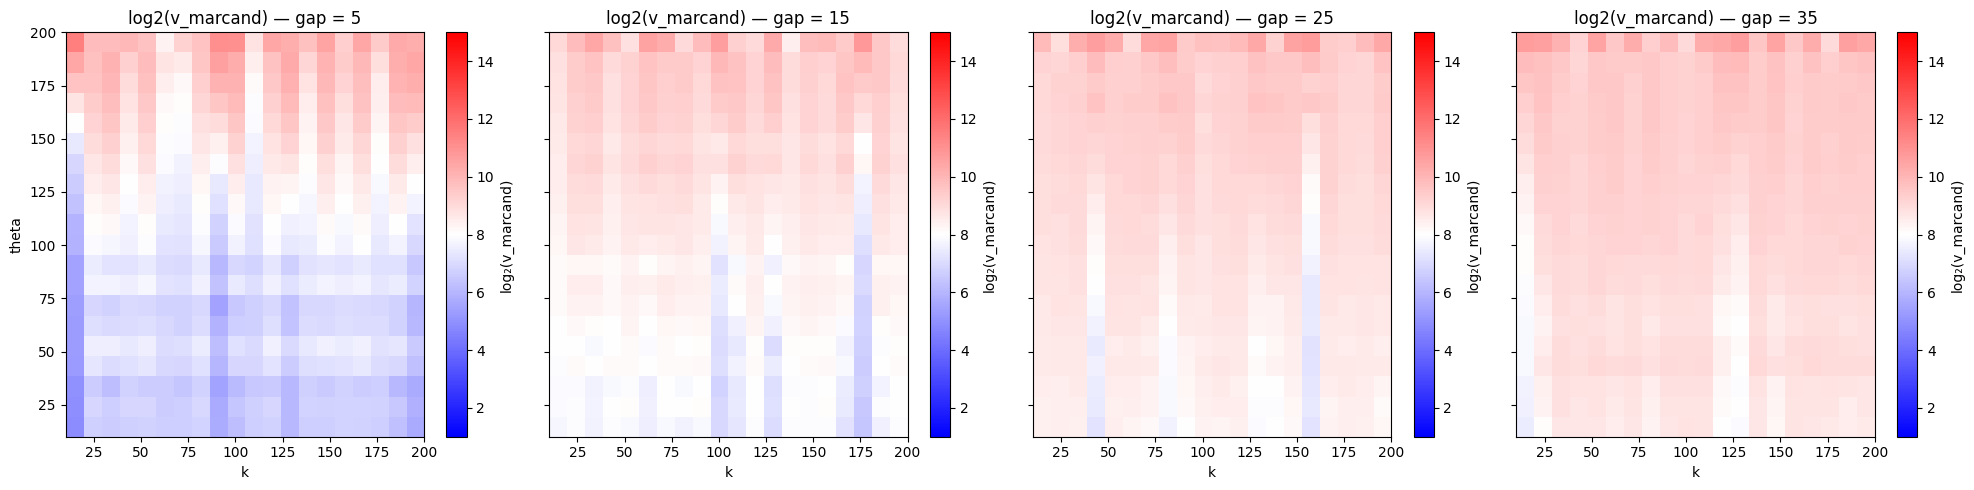

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Gaps à tracer
gap_values = [5, 15, 25, 35]

# Création de la figure
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for ax, gap_value in zip(axs, gap_values):
    df_gap = df_pl_mrc.filter(pl.col("gap") == gap_value)

    if df_gap.is_empty():
        ax.set_title(f"gap={gap_value} (vide)")
        continue

    try:
        pivot_df = df_gap.pivot(index="theta", columns="k", values="v_marcand", aggregate_function="first")
        pivot_df = pivot_df.sort("theta")
        pivot_df = pivot_df.sort(pivot_df.columns[1:])  # trie les k (colonnes après "theta")

        theta_vals = pivot_df["theta"].to_numpy()
        k_vals = np.array([int(col) for col in pivot_df.columns[1:]])
        v_grid_raw = np.array([pivot_df[col].to_numpy() for col in pivot_df.columns[1:]]).T

        # Application du log2
        with np.errstate(divide='ignore', invalid='ignore'):
            v_grid_log = np.log2(v_grid_raw)
            # v_grid_log = v_grid_raw
            v_grid_log[np.isneginf(v_grid_log)] = np.nan  # Pour éviter -inf visuel

        im = ax.imshow(v_grid_log, aspect='auto', origin='lower',
                       extent=[k_vals.min(), k_vals.max(), theta_vals.min(), theta_vals.max()],
                       cmap='bwr', vmin=1, vmax=15)

        ax.set_title(f"log2(v_marcand) — gap = {gap_value}")
        ax.set_xlabel("k")
        if ax is axs[0]:
            ax.set_ylabel("theta")

        fig.colorbar(im, ax=ax, orientation="vertical", label="log₂(v_marcand)")

    except Exception as e:
        ax.set_title(f"gap={gap_value} (erreur)")
        print(f"Erreur pour gap={gap_value} : {e}")

plt.tight_layout()
plt.show()



# III. Part C - Marcand : Graphical Representations (3D)

# III.1 Dynamic Representation in 3D

In [ ]:
def mrc_plotly_3D_v_marcand_log_and_linear(config_data):
    """
    Affiche deux sous-graphiques 3D (log2 et linéaire) de v_marcand pour une configuration donnée.
    
    Paramètres
    ----------
    config_data : dict
        Dictionnaire contenant les grilles mu, theta et les valeurs de v_marcand.
    """
    # Grille
    mu = config_data["mu_values"]
    theta = config_data["theta_values"]
    MU, THETA = np.meshgrid(mu, theta)
    config = config_data["config"]

    Z = np.array(config_data["v_marcand"])

    fig = make_subplots(
        rows=2, cols=1,
        specs=[[{'type': 'scene'}], [{'type': 'scene'}]],
        subplot_titles=["log₂(v_marcand)", "v_marcand (linéaire)"],
        vertical_spacing=0.12
    )

    # --- LOG2 subplot
    Z_log = np.log2(Z + 1e-10)
    scatter_log = go.Scatter3d(
        x=MU.flatten(), y=THETA.flatten(), z=Z_log.flatten(),
        mode='markers',
        marker=dict(
            size=3,
            color=Z_log.flatten(),
            colorscale='thermal',
            cmin=-2,
            cmax=2,
            colorbar=dict(
                title="log₂(v_marcand)",
                len=0.45,
                thickness=15,
                x=1.0,
                y=0.75,
                tickvals=[-2, -1, 0, 1, 2],
                ticktext=["−2", "−1", "0", "1", "2"]
            )
        ),
        showlegend=False
    )
    fig.add_trace(scatter_log, row=1, col=1)
    fig.update_scenes(
        dict(
            xaxis_title="mu",
            yaxis_title="theta",
            zaxis_title="log₂(v_marcand)",
            zaxis=dict(range=[-2, 2])
        ),
        row=1, col=1
    )

    # --- LIN subplot
    scatter_lin = go.Scatter3d(
        x=MU.flatten(), y=THETA.flatten(), z=Z.flatten(),
        mode='markers',
        marker=dict(
            size=3,
            color=Z.flatten(),
            colorscale='thermal',
            cmin=0,
            cmax=1,
            colorbar=dict(
                title="v_marcand",
                len=0.45,
                thickness=15,
                x=1.0,
                y=0.25,
                tickvals=[0, 0.25, 0.5, 0.75, 1],
                ticktext=["0", "0.25", "0.5", "0.75", "1"]
            )
        ),
        showlegend=False
    )
    fig.add_trace(scatter_lin, row=2, col=1)
    fig.update_scenes(
        dict(
            xaxis_title="mu",
            yaxis_title="theta",
            zaxis_title="v_marcand",
            zaxis=dict(range=[0, 1])
        ),
        row=2, col=1
    )

    # Layout global
    fig.update_layout(
        title=f"v_marcand — {config['alpha_choice']} — s={config['s']}, l={config['l']}, bpmin={config['bpmin']}",
        height=1000,
        width=1000,
        margin=dict(t=100, r=50, l=50)
    )

    fig.show()
    return None


mrc_plotly_3D_v_marcand_log_and_linear(config_data)

# .